# 1. Import Module

In [17]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
from rdkit.DataStructs import ExplicitBitVect

import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import sys
from tools import tools
from tools import  pipeline as p
from tools import  sar
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit    
import bz2
from glob import glob
import _pickle as cPickle
import pickle
# The next two lines are for optical reasons only. They can be safely disabled.
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18




## 2. Load sdf file 


In [2]:
# Function to read SDF file into DataFrame
def load_sdf_to_df(filename):
    suppl = Chem.SDMolSupplier(filename)
    rows = []
    for mol in suppl:
        if mol is not None:
            row = {prop: mol.GetProp(prop) for prop in mol.GetPropNames()}
            row['SMILES'] = Chem.MolToSmiles(mol)
            rows.append(row)
    return pd.DataFrame(rows)

# Load the train and test sets from SDF files
train_df = load_sdf_to_df('E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/data/train_set_acute_inhalation_features.sdf')
# Convert strings back to lists of integers
def string_to_list(bit_string):
    if isinstance(bit_string, str):
        return list(map(int, bit_string.strip('[]').split(', ')))
    else:
        return bit_string

train_df['Morgan_Descriptors'] = train_df['Morgan_Descriptors'].apply(string_to_list)
train_df['MACCS_Descriptors'] = train_df['MACCS_Descriptors'].apply(string_to_list)

print("Train DataFrame:")
print(train_df.head())


Train DataFrame:
               id        casrn smiles (First)    Molecular weight  \
0      4154; 4153  117428-22-5                 367.31915283203125   
1          314292      75-01-4          ClC=C   62.49821853637695   
2  274214; 274217     624-54-4  CCCCCOC(=O)CC  144.21144104003906   
3            1404     120-55-8                    314.33251953125   
4            1403     112-27-6                 150.17295837402344   

                                      name Outcome  \
0                    unnamed [117428-22-5]       1   
1                           Vinyl chloride       0   
2                        Pentyl propionate       0   
3   2-[2-(benzoyloxy)ethoxy]ethyl benzoate       0   
4  2-[2-(2-hydroxyethoxy)ethoxy]ethan-1-ol       0   

                   Molecule (RDKit Mol) (InChI Code) reference  molecule_form  \
0  InChI=1S/C18H16F3NO4/c1-24-11-14(17(23)25-2)13...      ECHA              A   
1                     InChI=1S/C2H3Cl/c1-2-3/h2H,1H2  ToxValDB  not specified   


In [3]:
train_df

,id,casrn,smiles (First),Molecular weight,name,Outcome,Molecule (RDKit Mol) (InChI Code),reference,molecule_form,ID,RowID,Morgan_Descriptors,MACCS_Descriptors,Modred_Descriptor,SMILES
0,4154; 4153,117428-22-5,,367.31915283203125,unnamed [117428-22-5],1,InChI=1S/C18H16F3NO4/c1-24-11-14(17(23)25-2)13...,ECHA,A,,456,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.701154774912237, 0.956977040760475, 1.01715...",COC=C(C(=O)OC)c1ccccc1COc1cccc(C(F)(F)F)n1
1,314292,75-01-4,ClC=C,62.49821853637695,Vinyl chloride,0,"InChI=1S/C2H3Cl/c1-2-3/h2H,1H2",ToxValDB,not specified,,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.0522731682205035, -2.532966941311662, -2.5...",C=CCl
2,274214; 274217,624-54-4,CCCCCOC(=O)CC,144.21144104003906,Pentyl propionate,0,"InChI=1S/C8H16O2/c1-3-5-6-7-10-8(9)4-2/h3-7H2,...",ToxValDB,not specified,,114,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.20738333489899805, -0.37947237262897193, -...",CCCCCOC(=O)CC
3,1404,120-55-8,,314.33251953125,2-[2-(benzoyloxy)ethoxy]ethyl benzoate,0,InChI=1S/C18H18O5/c19-17(15-7-3-1-4-8-15)22-13...,ECHA,A,,270,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.463196836781069, 0.43272206674311153, 0.482...",O=C(OCCOCCOC(=O)c1ccccc1)c1ccccc1
4,1403,112-27-6,,150.17295837402344,2-[2-(2-hydroxyethoxy)ethoxy]ethan-1-ol,0,"InChI=1S/C6H14O4/c7-1-3-9-5-6-10-4-2-8/h7-8H,1...",ECHA,A,,670,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.19663915302663465, -0.6979548097454424, -0...",OCCOCCOCCO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,2563,75-07-0,,44.05255889892578,acetaldehyde,0,"InChI=1S/C2H4O/c1-2-3/h2H,1H3",ECHA,V,,230,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.0522731682205035, -2.532966941311662, -2.5...",CC=O
537,1687,54112-23-1,,476.5673828125,2-oxo-N-[4-({4-[(2-oxoazepane-1-carbonyl)amino...,0,InChI=1S/C27H32N4O4/c32-24-7-3-1-5-17-30(24)26...,ECHA,A,,399,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.892691368473904, 0.824198682880224, 0.86233...",O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...
538,802640,80-05-7,CC(C)(c1ccc(O)cc1)c2ccc(O)cc2,228.28634643554688,Bisphenol A,0,"InChI=1S/C15H16O2/c1-15(2,11-3-7-13(16)8-4-11)...",ToxValDB,not specified,,52,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6349761023089422, 1.1229232366580275, 1.186...",CC(C)(c1ccc(O)cc1)c1ccc(O)cc1
539,3216,74-90-8,,27.025339126586914,formonitrile,1,InChI=1S/CHN/c1-2/h1H,ECHA,G,,507,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.129111810898681, -4.038768238723913, -4.07...",C#N


In [4]:
train_df= train_df.sort_values(['Outcome'], ascending=True)
train_df['RowID'] = train_df.index
train_df.head(100)

,id,casrn,smiles (First),Molecular weight,name,Outcome,Molecule (RDKit Mol) (InChI Code),reference,molecule_form,ID,RowID,Morgan_Descriptors,MACCS_Descriptors,Modred_Descriptor,SMILES
540,1237,482-89-3,,262.2628173828125,"2,2'-biindole-3,3'(1H,1'H)-dione",0,InChI=1S/C16H10N2O2/c19-15-9-5-1-3-7-11(9)17-1...,ECHA,A,,540,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.2010084300331483, 1.5202749240974005, 1.118...",O=C1C(=C2Nc3ccccc3C2=O)Nc2ccccc21
213,225,75-18-3,,62.13404083251953,(methylsulfanyl)methane,0,InChI=1S/C2H6S/c1-3-2/h1-2H3,ECHA,V,,213,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.0522731682205035, -2.532966941311662, -2.5...",CSC
212,183,73-32-5,,131.1729278564453,(2S)-2-amino-3-methylpentanoic acid,0,"InChI=1S/C6H13NO2/c1-3-4(2)5(7)6(8)9/h4-5H,3,7...",ECHA,A,,212,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.3783449134280008, 0.19497495607644622, 0.2...",CCC(C)C(N)C(=O)O
211,1346,629-15-2,,118.08804321289062,2-(formyloxy)ethyl formate,0,"InChI=1S/C4H6O4/c5-3-7-1-2-8-4-6/h3-4H,1-2H2",ECHA,A,,211,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.4318414936042256, -0.8419162812515544, -0....",O=COCCOC=O
445,299806; 299852,68526-56-7,CC/C=C/CC/C=C/C=C,136.23403930664062,"Alkenes, C9-?11, C10-?rich",0,"InChI=1S/C10H16/c1-3-5-7-9-10-8-6-4-2/h3,5-8H,...",ToxValDB,not specified,,445,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.19663915302663465, -0.6979548097454424, -0...",C=CC=CCCC=CCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,210897,112-53-8,CCCCCCCCCCCCO,186.33424377441406,1-Dodecanol,0,InChI=1S/C12H26O/c1-2-3-4-5-6-7-8-9-10-11-12-1...,ToxValDB,not specified,,357,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.14627986712685961, -0.5857327454219015, -0....",CCCCCCCCCCCCO
356,731,42532-60-5,,195.038330078125,-,0,"InChI=1S/C4F7N/c5-2(1-12,3(6,7)8)4(9,10)11",ECHA,G,,356,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.19840199799141442, 1.318490308737824, 1.38...",N#CC(F)(C(F)(F)F)C(F)(F)F
355,923,38640-62-9,,212.3300018310547,"1,2-bis(propan-2-yl)naphthalene",0,InChI=1S/C16H20/c1-11(2)13-7-5-10-16-14(12(3)4...,ECHA,A,,355,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5490009186634661, 1.2007939581621299, 1.265...",CC(C)c1cccc2c(C(C)C)cccc12
353,209113,1118-84-9,CC(=O)CC(=O)OCC=C,142.15249633789062,Allyl acetoacetate,0,"InChI=1S/C7H10O3/c1-3-4-10-7(9)5-6(2)8/h3H,1,4...",ToxValDB,not specified,,353,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.287915056692524, -0.14976171042604974, -0....",C=CCOC(=O)CC(C)=O


## 3.  data distribution

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


outcomes=(np.unique(train_df['Outcome']))
le.fit(list(set(outcomes)))
y = le.transform( train_df['Outcome'] )



print ("Classes                          : ",(outcomes))
print ("Number of cpds in each class     : ",np.unique([len(y[y==smi]) for smi in y]))
print ("Total number of cpds             : ",len(y))

S =train_df['Outcome']
info = {}
for i,cls in enumerate(S.unique()):
    info.update({cls:i})
    S = S.replace(cls,i)

Classes                          :  ['0' '1']
Number of cpds in each class     :  [265 276]
Total number of cpds             :  541


{'0': 0, '1': 1}

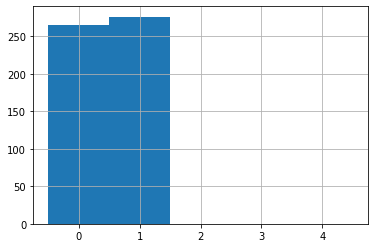

In [6]:
ax = S.hist(bins=np.arange(-0.5,5))
ax.set_xticks(range(0,5))
info

# 4. Read Modred Descriptor

In [7]:
y= np.int32((S))
def string_to_list(descriptor):
    if isinstance(descriptor, str):
        return list(map(float, descriptor.strip('[]').split(',')))
    return descriptor

# Apply the function to the 'Modred_Descriptor' column
train_df['Modred_Descriptor'] = train_df['Modred_Descriptor'].apply(string_to_list)

# Convert 'Modred_Descriptor' column to a NumPy array
x = np.array(train_df['Modred_Descriptor'].tolist())

# Print the shape of the resulting array
print(f"x.shape: {x.shape}")
print(x)

x.shape: (541, 742)
[[ 1.20100843  1.52027492  1.11853328 ...  1.58169302  0.02457478
   0.75114686]
 [-1.05227317 -2.53296694 -2.54080696 ... -0.99163784 -1.02175615
  -0.99574342]
 [-0.37834491  0.19497496  0.24030128 ... -0.35300099  0.08939174
  -0.34436061]
 ...
 [-0.94360692 -0.40344232 -0.36977888 ... -0.7662366  -0.41756949
  -0.99574342]
 [-0.49511486  0.6972458   0.40422496 ... -0.27786724 -0.46386732
  -0.66264994]
 [ 0.15734317  0.78475039  0.84157117 ...  0.32320274  0.44357013
   0.07015573]]


# 5. hyperparameter tuning with grid search_Modred

In [8]:
#Random Forest
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
# Define your parameter grid as before
paramgrid = {
    "max_features": [
        x.shape[1], x.shape[1] // 2, x.shape[1] // 4, x.shape[1] // 12, x.shape[1] // 10,
        x.shape[1] // 7, x.shape[1] // 5, x.shape[1] // 3
    ],
    "n_estimators": [10, 100, 300, 500],
}

# Define the cross-validator as before
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=24)

# Define the scoring function using Cohen's Kappa Score with quadratic weighting
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Everything else remains the same in your GridSearchCV initialization and fitting
model_rf_modred = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                     param_grid=paramgrid,
                     scoring=kappa_scorer,
                     cv=cv,
                     verbose=1,
                     n_jobs=1)  # Use -1 to use all cores

# Fit the model
model_rf_modred.fit(x, y)

# Get the best model
best_model_rf_modred = model_rf_modred.best_estimator_

# Optionally, fit the model with the best parameters (GridSearchCV automatically does this)
# best_model.fit(x, y)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [11]:
#XGB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, cohen_kappa_score

# Define your parameter grid
paramgrid = {
    "max_depth": [3, 5, 7, 10],  # Common choices for tree depth
    "n_estimators": [100, 200, 300],  # Number of trees
    "learning_rate": [0.01, 0.1, 0.2]  # Step size shrinkage used to prevent overfitting
}

# Define the cross-validator
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=24)

# Define the scoring function using Cohen's Kappa Score with quadratic weighting
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Set up the GridSearchCV with XGBClassifier
model_xgb_modred = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),  # use_label_encoder=False and eval_metric='mlogloss' to avoid warnings
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=cv,
    verbose=1,
    n_jobs=1  # Use -1 to use all cores
)

# Fit the model
model_xgb_modred.fit(x, y)

# Get the best model
best_model_xgb_modred = model_xgb_modred.best_estimator_

# Optionally, fit the model with the best parameters (GridSearchCV automatically does this)
# best_model.fit(x, y)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, cohen_kappa_score

# Define your parameter grid
paramgrid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],  # Type of the kernel
    "gamma": ['scale', 'auto']  # Kernel coefficient
}

# Define the cross-validator
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=24)

# Define the scoring function using Cohen's Kappa Score with quadratic weighting
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Set up the GridSearchCV with SVC
model_svm_modred = GridSearchCV(
    estimator=SVC(probability=True),  # probability=True if you need probability estimates
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=cv,
    verbose=1,
    n_jobs=1  # Use -1 to use all cores
)

# Fit the model
model_svm_modred.fit(x, y)

# Get the best model
best_model_svm_modred = model_svm_modred.best_estimator_

# Optionally, fit the model with the best parameters (GridSearchCV automatically does this)
# best_model.fit(x, y)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


# 6. Save model_Modred

In [10]:
import joblib
joblib.dump(best_model_rf_modred, 'E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Model_inhalation_toxicity_RF_modred.pkl',compress=9)

['E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Model_inhalation_toxicity_RF_modred.pkl']

In [12]:
import joblib
joblib.dump(best_model_xgb_modred, 'E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Model_inhalation_toxicity_XGB_modred.pkl',compress=9)

['E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Model_inhalation_toxicity_XGB_modred.pkl']

In [15]:
import joblib
joblib.dump(best_model_svm_modred, 'E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Model_inhalation_toxicity_SVM_modred.pkl',compress=9)

['E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Model_inhalation_toxicity_SVM_modred.pkl']

# 7. Train with best model_Modred

In [9]:
#Random Forest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Assume x, y, and best_model are defined elsewhere
#RF
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)

# Number of splits for cross-validation
n_splits = 5

# Prepare cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Lists to store results for various metrics
accuracies = []
auc_scores = []
precisions = []
recalls = []
f1_scores = []
specificities = []
sensitivity_scores = []
ppvs = []
npvs = []
ccrs = []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# Cross-validation loop
for train_index, test_index in cv.split(x, y):
    # Split data
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model
    best_model_rf_modred.fit(X_train, y_train)
    
    # Predictions and predicted probabilities
    y_pred = best_model_rf_modred.predict(X_test)
    y_proba = best_model_rf_modred.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    
    # Metrics calculation
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))  # Binary class AUC
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Sensitivity and Specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    # PPV and NPV
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    ppvs.append(ppv)
    npvs.append(npv)
    
    # CCR
    ccr = calculate_ccr(sensitivity, specificity)
    ccrs.append(ccr)

# Displaying the results
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i+1}:")
    print(cm)
    
print(f'Overall CV Accuracy: {np.mean(accuracies)}')
print(f'Overall CV AUC: {np.mean(auc_scores)}')
print(f'Overall CV Precision: {np.mean(precisions)}')
print(f'Overall CV Recall (Sensitivity): {np.mean(sensitivity_scores)}')
print(f'Overall CV F1 Score: {np.mean(f1_scores)}')
print(f'Overall CV Specificity: {np.mean(specificities)}')
print(f'Overall CV PPV (Positive Predictive Value): {np.mean(ppvs)}')
print(f'Overall CV NPV (Negative Predictive Value): {np.mean(npvs)}')
print(f'Overall CV CCR (Correct Classification Rate): {np.mean(ccrs)}')


Confusion Matrix for Fold 1:
[[42 11]
 [20 36]]
Confusion Matrix for Fold 2:
[[40 13]
 [ 9 46]]
Confusion Matrix for Fold 3:
[[41 12]
 [16 39]]
Confusion Matrix for Fold 4:
[[41 12]
 [16 39]]
Confusion Matrix for Fold 5:
[[40 13]
 [18 37]]
Overall CV Accuracy: 0.7412674142031939
Overall CV AUC: 0.8055305072286204
Overall CV Precision: 0.763006045692709
Overall CV Recall (Sensitivity): 0.714025974025974
Overall CV F1 Score: 0.7365013376085388
Overall CV Specificity: 0.769811320754717
Overall CV PPV (Positive Predictive Value): 0.763006045692709
Overall CV NPV (Negative Predictive Value): 0.7243995098185636
Overall CV CCR (Correct Classification Rate): 0.7419186473903455


In [13]:
#Random Forest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Assume x, y, and best_model are defined elsewhere
#RF
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)

# Number of splits for cross-validation
n_splits = 5

# Prepare cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Lists to store results for various metrics
accuracies = []
auc_scores = []
precisions = []
recalls = []
f1_scores = []
specificities = []
sensitivity_scores = []
ppvs = []
npvs = []
ccrs = []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# Cross-validation loop
for train_index, test_index in cv.split(x, y):
    # Split data
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model
    best_model_xgb_modred.fit(X_train, y_train)
    
    # Predictions and predicted probabilities
    y_pred = best_model_xgb_modred.predict(X_test)
    y_proba = best_model_xgb_modred.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    
    # Metrics calculation
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))  # Binary class AUC
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Sensitivity and Specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    # PPV and NPV
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    ppvs.append(ppv)
    npvs.append(npv)
    
    # CCR
    ccr = calculate_ccr(sensitivity, specificity)
    ccrs.append(ccr)

# Displaying the results
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i+1}:")
    print(cm)
    
print(f'Overall CV Accuracy: {np.mean(accuracies)}')
print(f'Overall CV AUC: {np.mean(auc_scores)}')
print(f'Overall CV Precision: {np.mean(precisions)}')
print(f'Overall CV Recall (Sensitivity): {np.mean(sensitivity_scores)}')
print(f'Overall CV F1 Score: {np.mean(f1_scores)}')
print(f'Overall CV Specificity: {np.mean(specificities)}')
print(f'Overall CV PPV (Positive Predictive Value): {np.mean(ppvs)}')
print(f'Overall CV NPV (Negative Predictive Value): {np.mean(npvs)}')
print(f'Overall CV CCR (Correct Classification Rate): {np.mean(ccrs)}')


Confusion Matrix for Fold 1:
[[41 12]
 [18 38]]
Confusion Matrix for Fold 2:
[[40 13]
 [12 43]]
Confusion Matrix for Fold 3:
[[40 13]
 [16 39]]
Confusion Matrix for Fold 4:
[[37 16]
 [14 41]]
Confusion Matrix for Fold 5:
[[37 16]
 [18 37]]
Overall CV Accuracy: 0.7264356099218484
Overall CV AUC: 0.792989463366822
Overall CV Precision: 0.7390537192036696
Overall CV Recall (Sensitivity): 0.7175324675324676
Overall CV F1 Score: 0.7276111823590223
Overall CV Specificity: 0.7358490566037736
Overall CV PPV (Positive Predictive Value): 0.7390537192036696
Overall CV NPV (Negative Predictive Value): 0.7153298413118951
Overall CV CCR (Correct Classification Rate): 0.7266907620681206


In [16]:
#SVM
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Assume x, y, and best_model are defined elsewhere
#RF
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)

# Number of splits for cross-validation
n_splits = 5

# Prepare cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Lists to store results for various metrics
accuracies = []
auc_scores = []
precisions = []
recalls = []
f1_scores = []
specificities = []
sensitivity_scores = []
ppvs = []
npvs = []
ccrs = []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# Cross-validation loop
for train_index, test_index in cv.split(x, y):
    # Split data
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model
    best_model_svm_modred.fit(X_train, y_train)
    
    # Predictions and predicted probabilities
    y_pred = best_model_svm_modred.predict(X_test)
    y_proba = best_model_svm_modred.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    
    # Metrics calculation
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))  # Binary class AUC
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Sensitivity and Specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    # PPV and NPV
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    ppvs.append(ppv)
    npvs.append(npv)
    
    # CCR
    ccr = calculate_ccr(sensitivity, specificity)
    ccrs.append(ccr)

# Displaying the results
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i+1}:")
    print(cm)
    
print(f'Overall CV Accuracy: {np.mean(accuracies)}')
print(f'Overall CV AUC: {np.mean(auc_scores)}')
print(f'Overall CV Precision: {np.mean(precisions)}')
print(f'Overall CV Recall (Sensitivity): {np.mean(sensitivity_scores)}')
print(f'Overall CV F1 Score: {np.mean(f1_scores)}')
print(f'Overall CV Specificity: {np.mean(specificities)}')
print(f'Overall CV PPV (Positive Predictive Value): {np.mean(ppvs)}')
print(f'Overall CV NPV (Negative Predictive Value): {np.mean(npvs)}')
print(f'Overall CV CCR (Correct Classification Rate): {np.mean(ccrs)}')


Confusion Matrix for Fold 1:
[[39 14]
 [19 37]]
Confusion Matrix for Fold 2:
[[38 15]
 [12 43]]
Confusion Matrix for Fold 3:
[[40 13]
 [15 40]]
Confusion Matrix for Fold 4:
[[38 15]
 [16 39]]
Confusion Matrix for Fold 5:
[[39 14]
 [19 36]]
Overall CV Accuracy: 0.7190791709140333
Overall CV AUC: 0.7821881891693213
Overall CV Precision: 0.7327617419555112
Overall CV Recall (Sensitivity): 0.7066883116883117
Overall CV F1 Score: 0.7189404177359279
Overall CV Specificity: 0.7320754716981132
Overall CV PPV (Positive Predictive Value): 0.7327617419555112
Overall CV NPV (Negative Predictive Value): 0.7071608034366655
Overall CV CCR (Correct Classification Rate): 0.7193818916932125
